In [78]:
!git clone https://github.com/Antonomaz/Corpus.git 2> nul || cd Corpus && git pull

Already up to date.


In [79]:
# !./venv/bin/python -m pip install -U pip
# !./venv/bin/python -m pip install -r requirements.txt

In [80]:
from bs4 import BeautifulSoup
from pprint import pprint
from glob import glob
import json
from numpy import mean, std, amax, amin
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from collections import Counter
from pprint import pprint
import xmltodict
import contextlib
from random import sample


In [81]:
def ttr(chaine):
    chaine = chaine.split()
    return len([word for word in chaine if word in mots_LGERM])/len(chaine)

def tok_voc_ratio(str_):
    if not str_:
        return
    lstr = str_.split()
    return len(set(lstr))/len(lstr)

def compte_hapax(str):
    ct = Counter(str)
    return len([val for val in ct.values() if val == 1])

def eval_sub_type(str_):
    if str_ == "no":
        return False
    elif str_ == "yes":
        return True
    else:
        return str_


In [82]:
with open("LGERM.json", encoding="utf-8") as f:
    LGERM = json.load(f)
mots_LGERM = set(LGERM)

path = "Corpus/Mazarinades/*/*.xml"

files = glob(path)

print(len(files))

3065


Distribution mots outils

OCR performance prediction using cross-OCR
alignment
Ahmed BEN SALAH*, Jean philippe MOREUXt
, Nicolas RAGOT+ and Thierry PAQUET§

https://dl.acm.org/doi/pdf/10.1145/2595188.2595221


In [83]:
sample_mode = False

if sample_mode:
    files = sample(files, 3000)



dict_stats = {}

for i, file in enumerate(tqdm(files)):
    with open(file, encoding="utf-8") as f:
        txt = f.read()


    dict_ = xmltodict.parse(txt)
    dict_ = dict_["TEI"]["teiHeader"]
    header = dict_["profileDesc"]["textClass"]["keywords"]["term"]
    header = [{header["@type"] : header["#text"] if "#text" in header else eval_sub_type(header["@subtype"]) if "@subtype" in header else None} for header in header]

    dict_header = {}
    for dicts in header:
        for k, v in dicts.items():
            if k not in dict_header:
                dict_header[k] = []
            dict_header[k].append(v)

    dict_header = {k : v if len(v) > 1 else v[0] for k, v in dict_header.items()}

    with contextlib.suppress(KeyError):
        creation = dict_["profileDesc"]["settingDesc"]["setting"]["date"]
        if creation is None:
            dict_header["creation"] = "00-00-0000"
        else:
            dict_header["creation"] = creation["@when"] if "@when" in creation else creation["#text"]

    dict_header["change"] = dict_["revisionDesc"]["change"]

    titre = dict_["fileDesc"]["titleStmt"]["title"]
    titre = [e for e in titre if e["@type"] == "main"][0]["#text"]
    dict_header["titre"] = titre if isinstance(titre, str) else " ".join(titre)

    dict_header["dates"] = dict_["fileDesc"]["publicationStmt"]["date"]



    tei_head = re.search(r"<teiHeader>.*?</teiHeader>", txt, re.DOTALL).group()

    soup = BeautifulSoup(tei_head, "html.parser")

    elts = {
        e.tag: e.text
        for e in soup.find_all()
    }


    txt = re.split(r"(?:<pb .*?>)", txt)[1:]
    txt = [re.split(r"\n|<lb/>|<l>", line) for line in txt]
    txt = [[re.sub(r"<.*?>|  |\t", "", line) for line in page] for page in txt]
    txt = [[line for line in page if line.strip()] for page in txt]
    txt = [page for page in txt if page]

    pages = [' '.join(line for line in page) for page in txt]

    plain = ' '.join(mot for page in txt for line in page for mot in line)

    if not txt:
        print(f"Empty file: {file}, {i = }")
        continue

    dict_stats[file] = {
        "pages": len(txt),
        "lines": sum(len(page) for page in txt),
        "words": sum(len(line.split()) for page in txt for line in page),
        "chars": sum(len(line) for page in txt for line in page),
        "ttr": ttr(plain),
        "tok_voc_ratio": tok_voc_ratio(plain),
        "hapax": compte_hapax(plain),
        "hapax_ratio": compte_hapax(plain)/len(plain.split()),
        "ttrs": [ttr(page) for page in pages],
        "header": dict_header,
    }


  0%|          | 0/3065 [00:00<?, ?it/s]

Empty file: Corpus/Mazarinades/1201-1300/Moreau1240_GALL.xml, i = 879


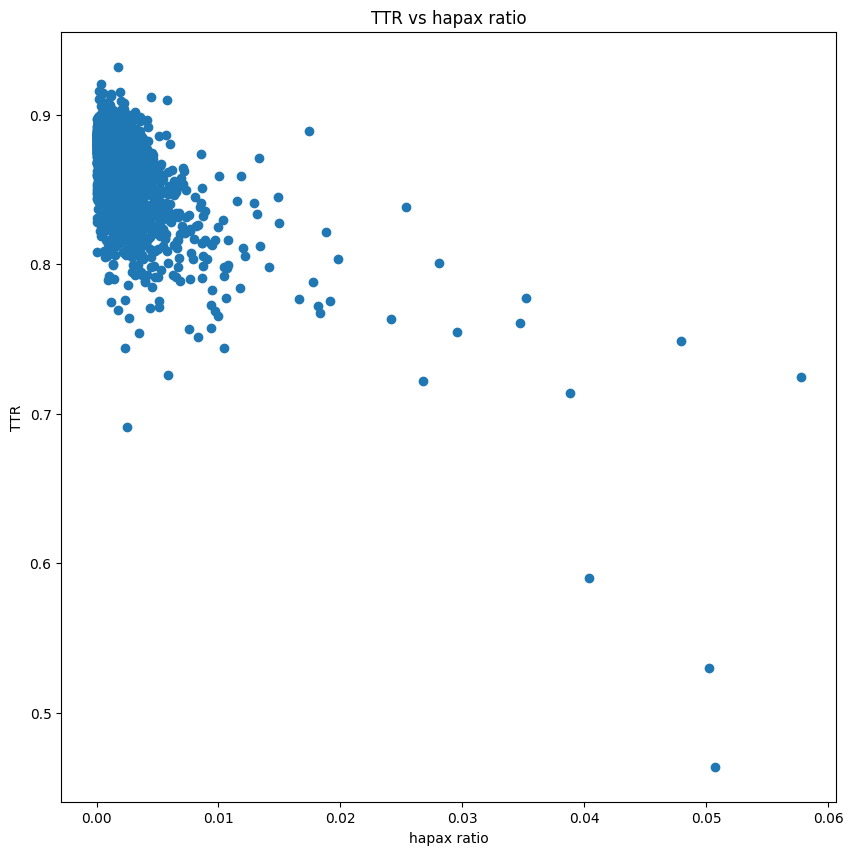

In [84]:
tup = [(val["hapax_ratio"], val["ttr"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("TTR vs hapax ratio")
plt.xlabel("hapax ratio")
plt.ylabel("TTR")

plt.scatter(*zip(*tup))

plt.show()

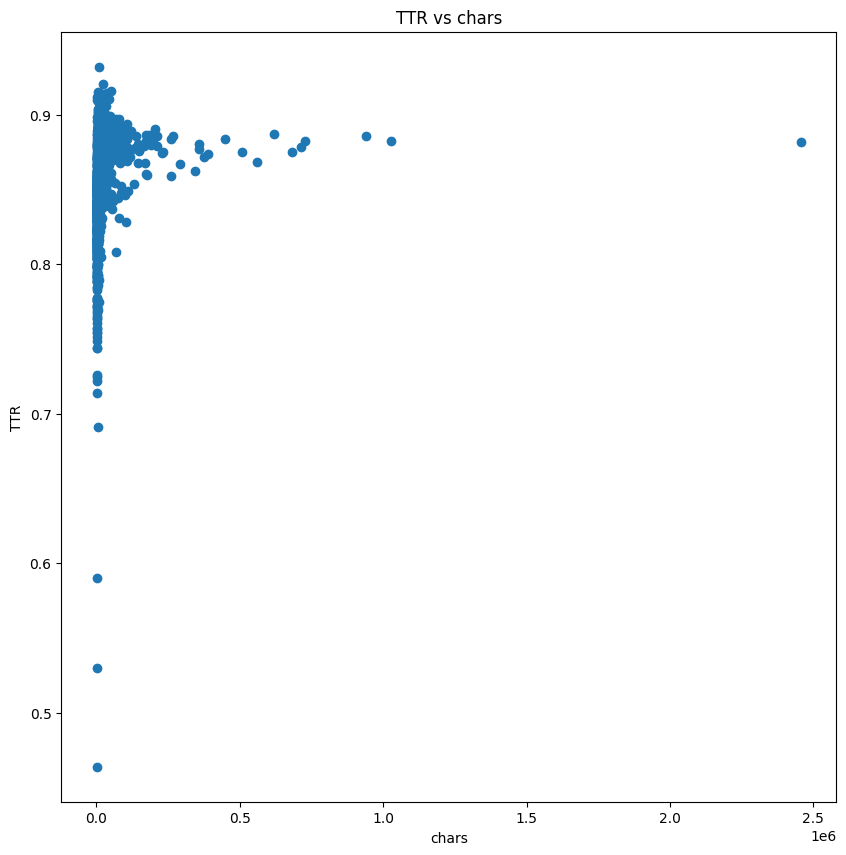

In [85]:
tup = [(val["chars"], val["ttr"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("TTR vs chars")
plt.xlabel("chars")
plt.ylabel("TTR")

plt.scatter(*zip(*tup))


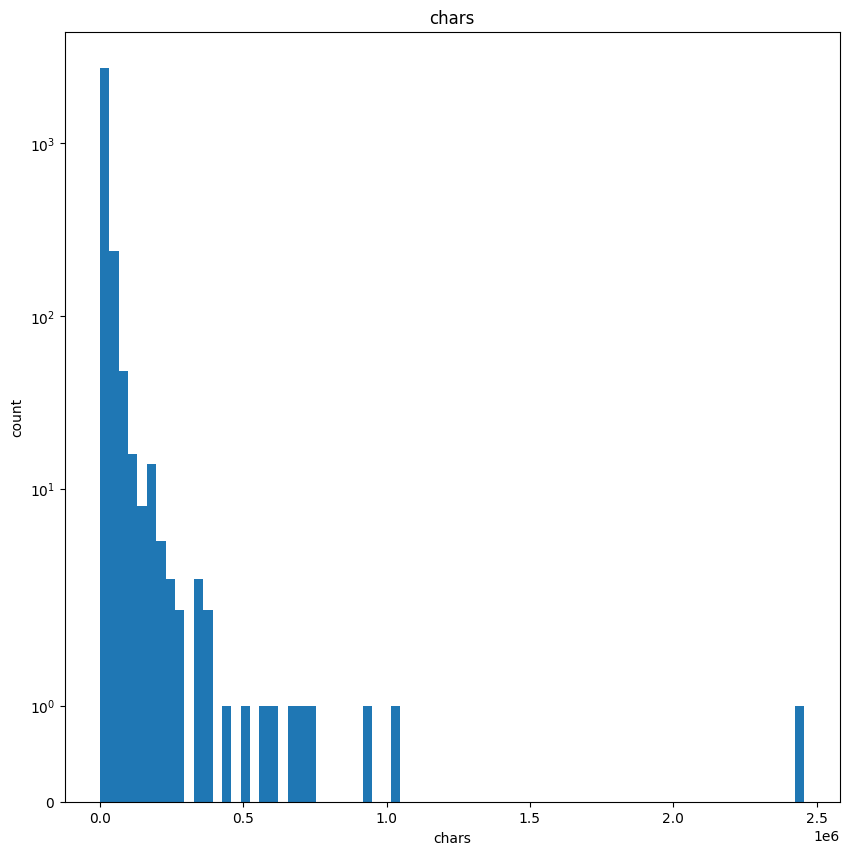

In [86]:
x = [v["chars"] for v in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("chars")
plt.xlabel("chars")
plt.ylabel("count")
plt.xscale('linear')
plt.yscale('symlog', linscale=1)
plt.hist(x, bins=75)

plt.show()

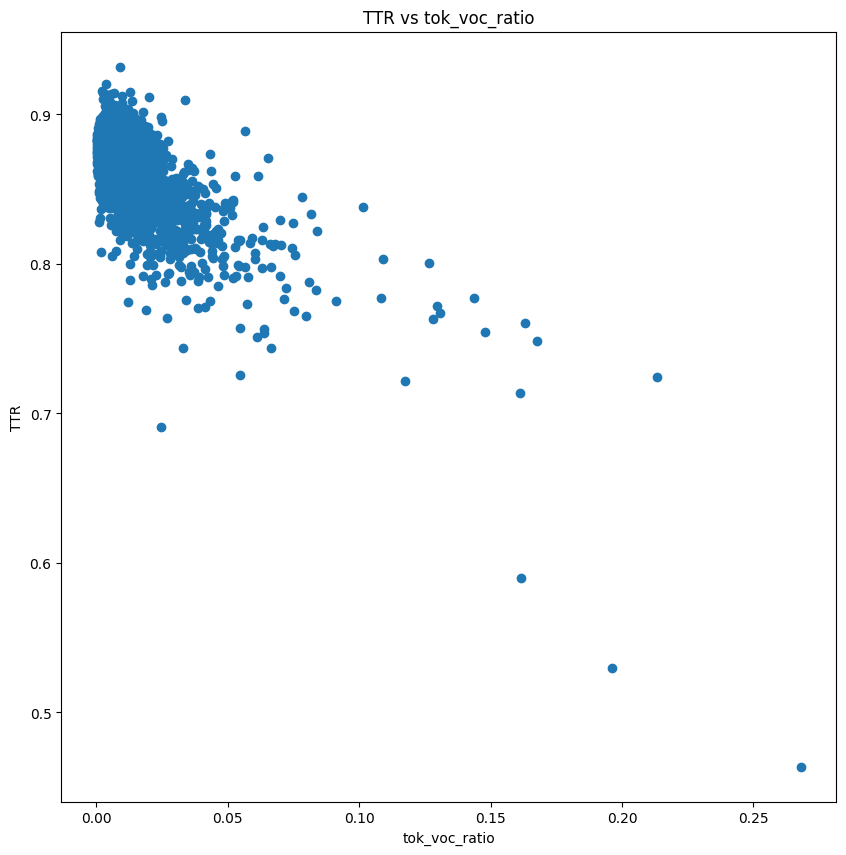

In [87]:
tup = [(val["tok_voc_ratio"], val["ttr"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("TTR vs tok_voc_ratio")
plt.xlabel("tok_voc_ratio")
plt.ylabel("TTR")

plt.scatter(*zip(*tup))

plt.show()

In [91]:
x = [val["header"]["change"]["@status"] if isinstance(val["header"]["change"], dict) else val["header"]["change"][0]["@status"] for val in dict_stats.values()]
len(x)/ len([e for e in x if e == "corrected"])

1.0

In [92]:
for txt, val in dict_stats.items():
    pprint(val["header"])
    break

{'change': {'@status': 'corrected', '@when': '2022-07-11', '@who': 'AB'},
 'creation': '1652-07-11',
 'dates': {'#text': '2 novembre 2021',
           '@type': 'file_creation',
           '@when': '2021-11-02'},
 'form': 'prose',
 'genre': ['récit', 'relation'],
 'handwritten_note': False,
 'illustration': False,
 'table_of_content': False,
 'titre': "Relation véritable de ce qui s'est fait et passé dans\n"
          "          l'audience donnée à Saint-Denys, le onzième juillet 1652, "
          'à messieurs les députés du\n'
          '          Parlement, avec les propres termes de la réponse à eux '
          'faite de la part du roi par\n'
          '          monsieur le garde des sceaux.'}


In [93]:
val["tok_voc_ratio"]

0.011186387269576178

prose: 0.013
vers: 0.018
('vers', 'prose'): 0.010
('prose', 'récit'): 0.015
('prose', 'manifeste'): 0.005


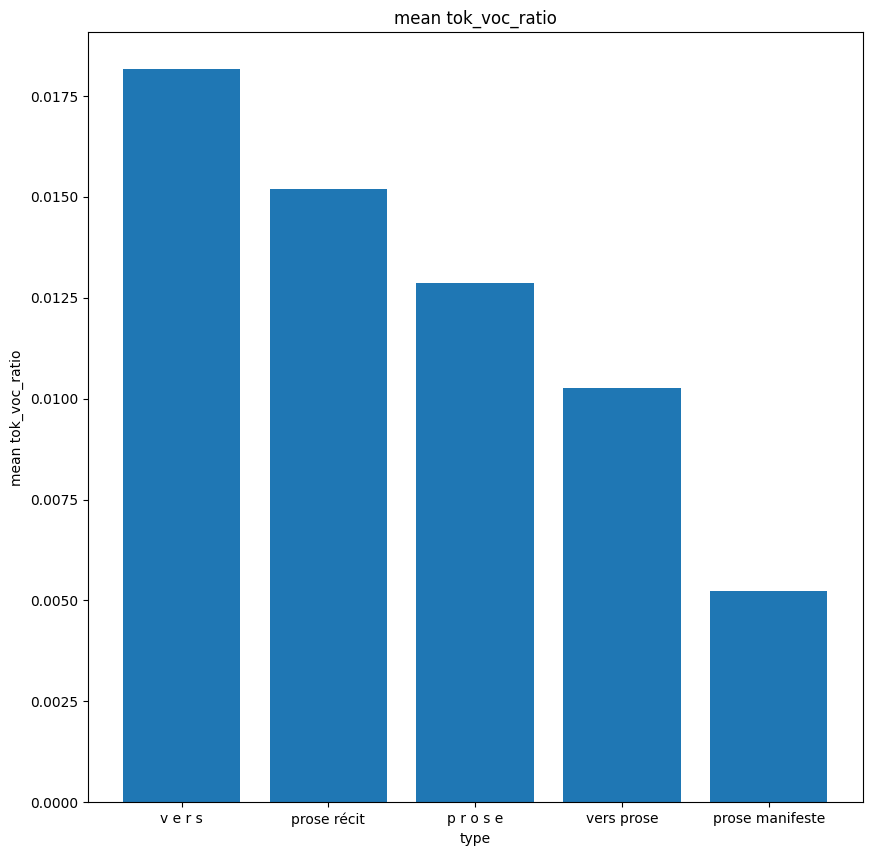

In [94]:
def stats(key):
    stats = {}
    for txt, val in dict_stats.items():
        type_ = val["header"]["form"] if isinstance(val["header"]["form"], str) else tuple(val["header"]["form"])

        if type_ not in stats:
            for e in stats.keys():
                if set(e) == set(type_):
                    type_ = e
                    break
            else:
                stats[type_] = []

        stats[type_].append(mean(val[key]))

    for k, v in stats.items():
        print(f"{k}: {mean(v):.3f}")

    plot = [(" ".join(k), mean(v)) for k, v in stats.items()]
    plot = sorted(plot, key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 10))
    plt.title(f"mean {key}")
    plt.xlabel("type")
    plt.ylabel(f"mean {key}")

    plt.bar(*zip(*plot))

    plt.show()

stats("tok_voc_ratio")

prose: 0.871
vers: 0.842
('vers', 'prose'): 0.868
('prose', 'récit'): 0.859
('prose', 'manifeste'): 0.870


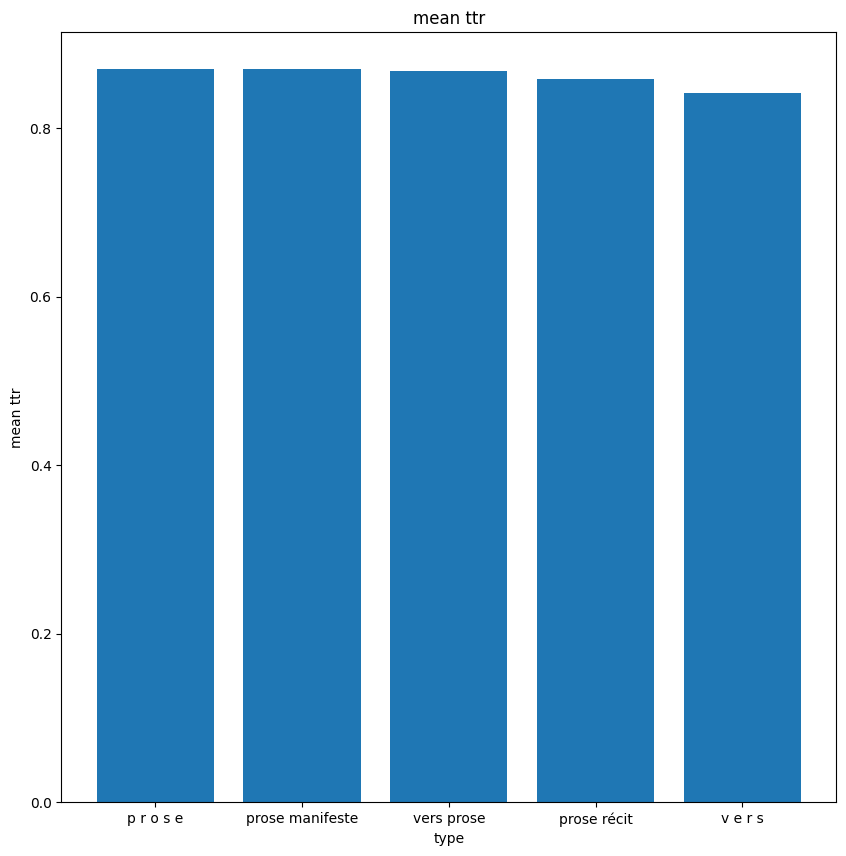

In [95]:
stats("ttr")


prose: 0.002
vers: 0.002
('vers', 'prose'): 0.001
('prose', 'récit'): 0.001
('prose', 'manifeste'): 0.001


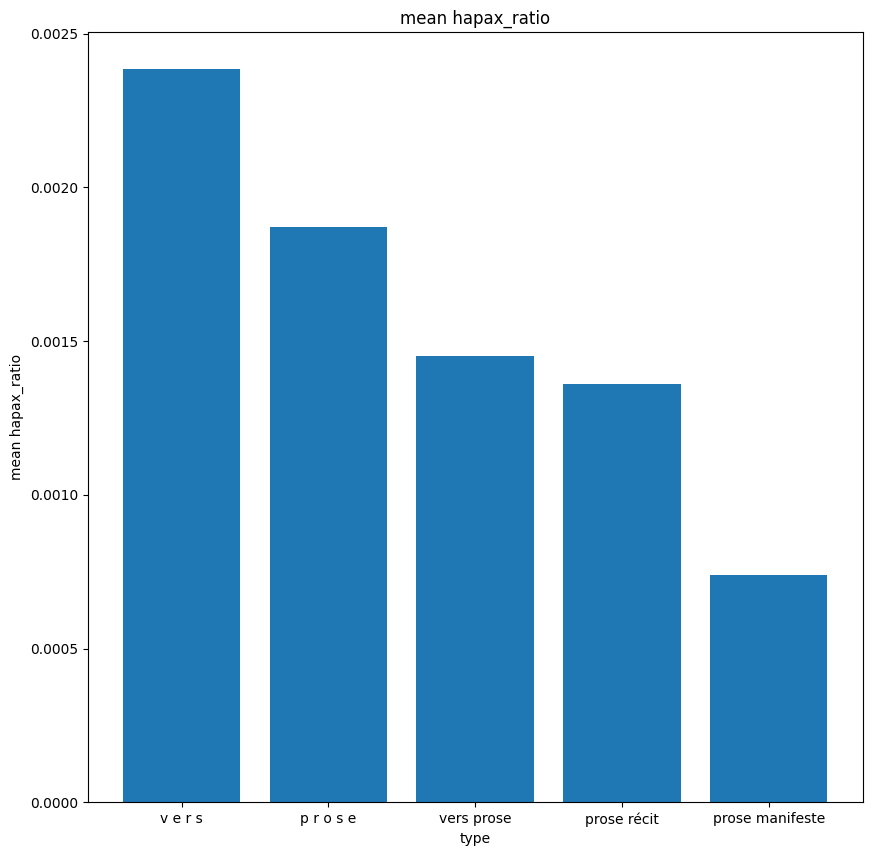

In [96]:
stats("hapax_ratio")

1652-07-11: 0.002
1652-09-26: 0.002
1649-03-04: 0.002
1652-04-28: 0.001
1650-10-01: 0.002
1649-02-19: 0.002
1648-04: 0.001
1652-07-13: 0.001
1652-08-07: 0.002
1652-03-16: 0.002
1651-10-08: 0.003
1652-02-28: 0.002
1652-04-07: 0.002
('vers', 'prose'): 0.002
1652-01-01: 0.002
1649-01-18: 0.002
1651-04-18: 0.001
1649-04-01: 0.002
00-00-0000: 0.002
1652-05-04: 0.003
1649-09-05: 0.002
1651-07-06: 0.002
1649-12-11: 0.001
1650-05-09: 0.001
1649-03-15: 0.003
1649-02-08: 0.002
1651-04-05: 0.001
1652-08-19: 0.001
1649-02-03: 0.002
1651-09-07: 0.001
1649-07-17: 0.002
1651-09-13: 0.001
1651-03-11: 0.002
1651-08-17: 0.001
1650-07-04: 0.002
1652-09-24: 0.001
1652-08-23: 0.002
1651-12-12: 0.003
('prose', 'manifeste'): 0.001


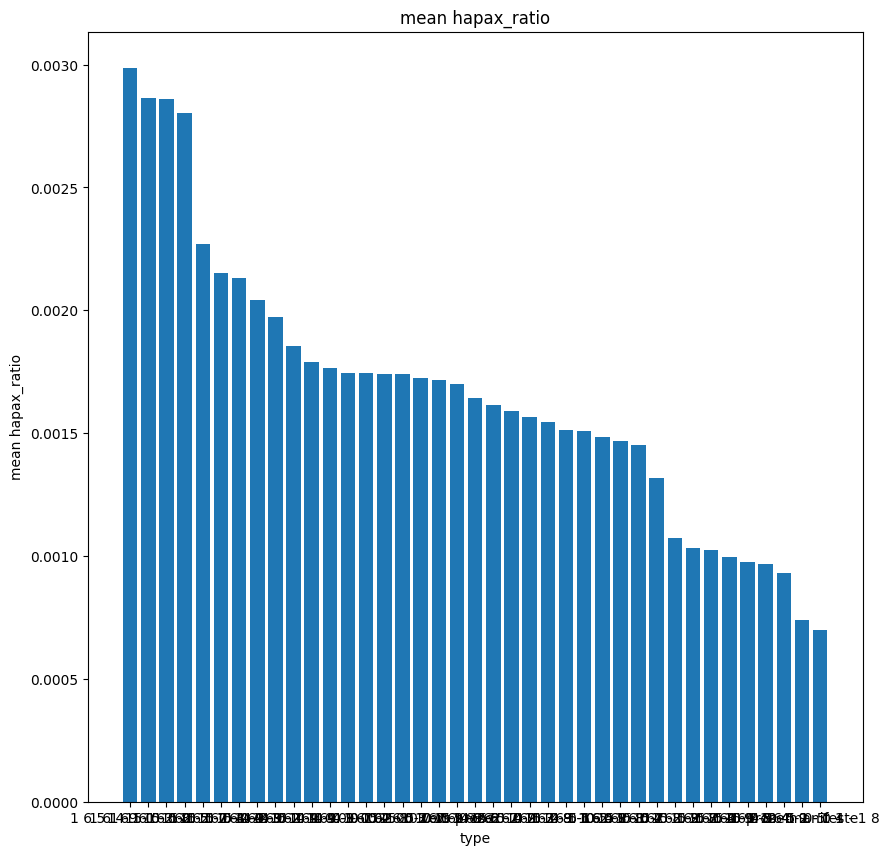

In [97]:
def stats2(header_prop, stats_prop):
    stats = {}
    for txt, val in dict_stats.items():
        if header_prop not in val["header"]:
            continue

        type_ = val["header"][header_prop] if isinstance(val["header"]["form"], str) else tuple(val["header"]["form"])


        if isinstance(type_, bool):
                type_ = str(type_)


        if type_ not in stats:
            for e in stats.keys():
                if set(e) == set(type_):
                    type_ = e
                    break
            else:
                stats[type_] = []

        stats[type_].append(mean(val[stats_prop]))

    for k, v in stats.items():
        print(f"{k}: {mean(v):.3f}")

    plot = [(" ".join(k), mean(v)) for k, v in stats.items()]
    plot = sorted(plot, key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 10))
    plt.title(f"mean {stats_prop}")
    plt.xlabel("type")
    plt.ylabel(f"mean {stats_prop}")

    plt.bar(*zip(*plot))

    plt.show()

stats2("creation", "hapax_ratio")

1652-07-11: 0.012
1652-09-26: 0.011
1649-03-04: 0.013
1652-04-28: 0.008
1650-10-01: 0.016
1649-02-19: 0.014
1648-04: 0.011
1652-07-13: 0.011
1652-08-07: 0.011
1652-03-16: 0.011
1651-10-08: 0.019
1652-02-28: 0.011
1652-04-07: 0.011
('vers', 'prose'): 0.012
1652-01-01: 0.011
1649-01-18: 0.013
1651-04-18: 0.006
1649-04-01: 0.014
00-00-0000: 0.013
1652-05-04: 0.016
1649-09-05: 0.013
1651-07-06: 0.012
1649-12-11: 0.008
1650-05-09: 0.007
1649-03-15: 0.016
1649-02-08: 0.012
1651-04-05: 0.008
1652-08-19: 0.008
1649-02-03: 0.013
1651-09-07: 0.011
1649-07-17: 0.011
1651-09-13: 0.007
1651-03-11: 0.016
1651-08-17: 0.010
1650-07-04: 0.016
1652-09-24: 0.009
1652-08-23: 0.016
1651-12-12: 0.019
('prose', 'manifeste'): 0.005


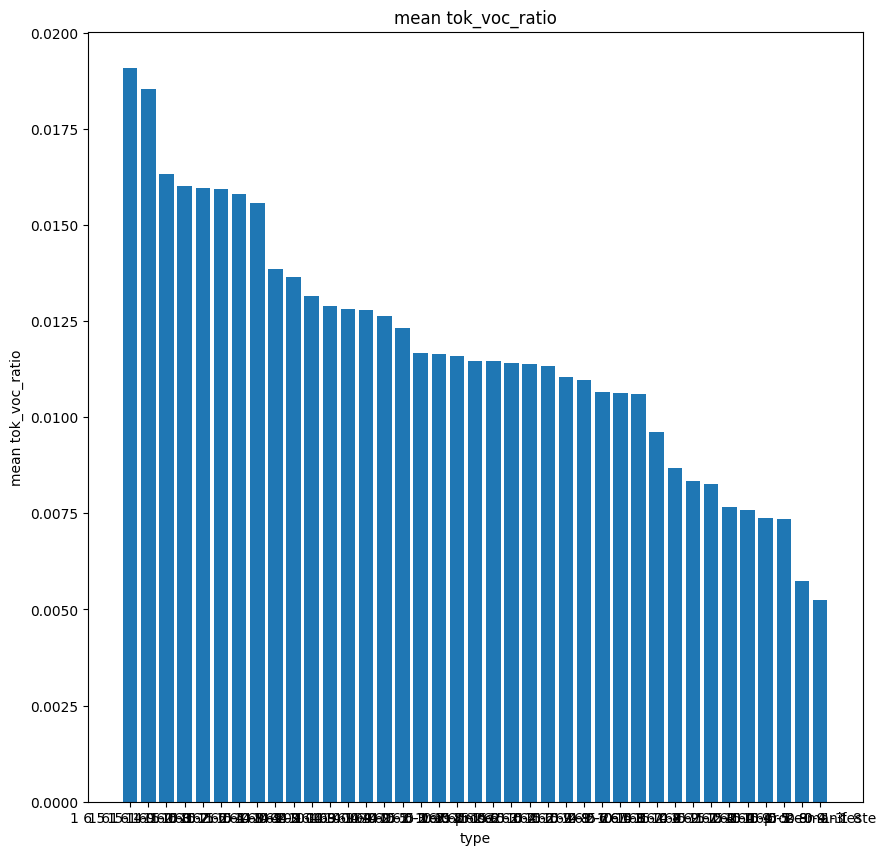

In [98]:
stats2("creation", "tok_voc_ratio")

False: 16624.920
('vers', 'prose'): 46464.446
True: 89307.689
('prose', 'récit'): 5171.000
('prose', 'manifeste'): 19144.000


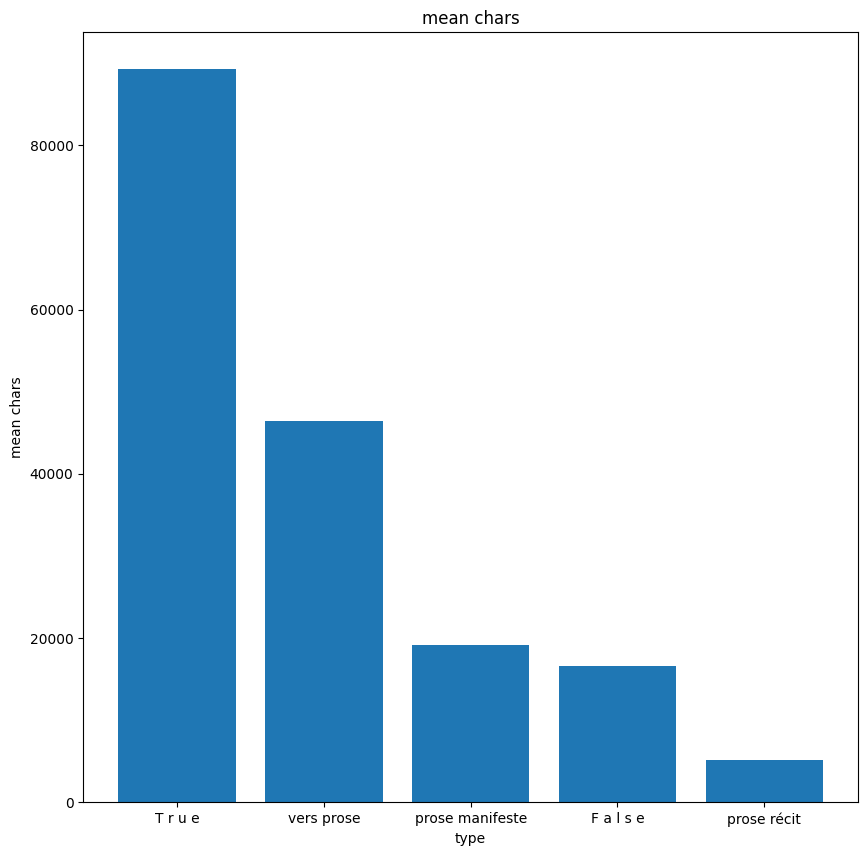

False: 0.014
('vers', 'prose'): 0.010
True: 0.003
('prose', 'récit'): 0.015
('prose', 'manifeste'): 0.005


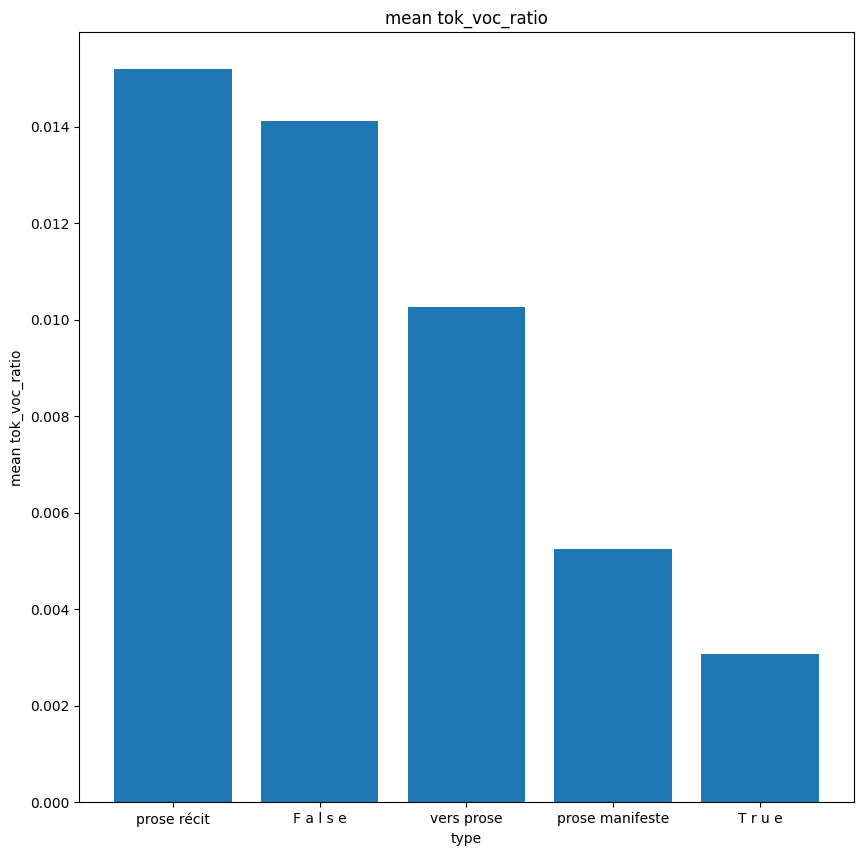

In [99]:
stats2("table_of_content", "chars")
stats2("table_of_content", "tok_voc_ratio")

In [100]:
for txt, val in dict_stats.items():
    pprint(val)
    break

{'chars': 7521,
 'hapax': 8,
 'hapax_ratio': 0.0012604380022057666,
 'header': {'change': {'@status': 'corrected',
                       '@when': '2022-07-11',
                       '@who': 'AB'},
            'creation': '1652-07-11',
            'dates': {'#text': '2 novembre 2021',
                      '@type': 'file_creation',
                      '@when': '2021-11-02'},
            'form': 'prose',
            'genre': ['récit', 'relation'],
            'handwritten_note': False,
            'illustration': False,
            'table_of_content': False,
            'titre': "Relation véritable de ce qui s'est fait et passé dans\n"
                     "          l'audience donnée à Saint-Denys, le onzième "
                     'juillet 1652, à messieurs les députés du\n'
                     '          Parlement, avec les propres termes de la '
                     'réponse à eux faite de la part du roi par\n'
                     '          monsieur le garde des sceaux.'},
 'l